![Practicum AI Logo image](https://github.com/PracticumAI/deep_learning_pt-lightning/blob/main/images/practicum_ai_logo.png?raw=1) <img src='https://github.com/PracticumAI/deep_learning_pt-lightning/blob/main/images/practicumai_deep_learning.png?raw=1' alt='Practicum AI: Deep Learning Foundations icon' align='right' width=50>

***
# Hyperparameter Optimization

Amelia's nutrition study is going so well that her colleagues have heard about her growing AI skills! An entomologist colleague reached out to Amelia for help with their project. They would like to classify images as being a bee, a wasp, some other insect, or none of these.

Luckily, the entomologist colleague knows about the popular online repository of datasets, Kaggle, and already found a great dataset of images to use! [Check out the dataset information](https://www.kaggle.com/datasets/jerzydziewierz/bee-vs-wasp). [![Image of bees and wasps from the dataset cover image](https://github.com/PracticumAI/deep_learning_pt-lightning/blob/main/images/bees_wasps_dataset-cover.png?raw=1)]((https://www.kaggle.com/datasets/jerzydziewierz/bee-vs-wasp))


## 1. Import the libraries we will use

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback

import pandas as pd  # Import the pandas library, used for data manipulation and analysis.

# Used for data management
import requests
import os
import time
import tarfile

import matplotlib.pyplot as plt  # Import the matplotlib library for plotting and visualization.


from sklearn.metrics import confusion_matrix
import numpy as np
from PIL import Image

Check for GPU availability
This cell will check that everything is configured correctly to use your GPU. If everything is correct, you should see something like:

    Using GPU: [type of GPU]

If you see:

    Using CPU

Either you do not have a GPU or the kernel is not correctly configured to use it. You might be able to run this notebook, but some sections will take a loooooong time!

In [2]:
# Check for GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name()}")
    print("Setting Torch precision to medium for faster performance")
    torch.set_float32_matmul_precision("medium")
else:
    print("Using CPU")

Using GPU: NVIDIA A100-SXM4-80GB MIG 1g.10gb
Setting Torch precision to medium for faster performance


In [3]:
# Set the number of workers to use for data loading
num_workers = None  # To manually set the number of workers, change this to an integer

if num_workers is None:
    # If Slurm is being used, set the number of workers to a Slurm-provided value.
    # If Slurm is not being used, set the number of workers to the number of available CPU cores.
    if os.getenv("SLURM_CPUS_PER_TASK") is not None:
        num_workers = int(os.getenv("SLURM_CPUS_PER_TASK"))
    elif os.getenv("SLURM_NTASKS_PER_NODE") is not None:
        num_workers = int(os.getenv("SLURM_NTASKS_PER_NODE"))
    elif os.getenv("SLURM_NTASKS") is not None:
        num_workers = int(os.getenv("SLURM_NTASKS"))
    else:
        num_workers = os.cpu_count()

print(f"Using {num_workers} workers for data loading.")

Using 3 workers for data loading.


## 2. Getting the data

Even once we have identified the dataset we want to use, getting it can be a challenge. Many AI datasets are large, require authentication even for free datasets, and may require some cleanup before working with them.

You can download the data from Kaggle, but need a free account. Additional steps are also needed to get the data into a usable format.

Git and GitHub.com are generally not well suited to large files (GitHub's limit is generally about 100Mb per file). And if we add all the images individually to the repository, the about 20,000 image files make operations take a long time.

If you are doing this as part of a workshop, we will provide the path to the data.

We do have the dataset [hosted for download on HiPerGator as a `tar.gz` file](https://data.rc.ufl.edu/pub/practicum-ai/Deep_Learning_Foundations/bee_vs_wasp.tar.gz) that you can download and should be ready to use.

### If needed, download the dataset

The following code block is quite large. **You do not need to understand everything!** This block will look for the data files required for this notebook in some common locations. If it can't find the data, it will ask if you know where it is. If you do, answer yes and provide the path to the data (up to and including the `bee_vs_wasp` folder name). If not, it will ask if you want to download it. If you answer yes, it will download the data and extract it into your data folder.

In [4]:
def download_file(
    url="https://data.rc.ufl.edu/pub/practicum-ai/Deep_Learning_Foundations/bee_vs_wasp.tar.gz",
    filename="bee_vs_wasp.tar.gz",
):

    # Download the file using requests
    response = requests.get(url, stream=True)

    # Create a file object and write the response content in chunks
    with open(filename, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    # Wait for the file to finish downloading
    while not os.path.exists(filename):
        time.sleep(1)

    # Print a success message
    print(f"Downloaded {filename} successfully.")


def extract_file(filename, data_folder):
    # Check if the file is a tar file
    if tarfile.is_tarfile(filename):
        # Open the tar file
        tar = tarfile.open(filename, "r:gz")
        # Extract all the files to the data folder
        tar.extractall(data_folder)
        # Close the tar file
        tar.close()
        # Print a success message
        print(f"Extracted {filename} to {data_folder} successfully.")
    else:
        # Print an error message
        print(f"{filename} is not a valid tar file.")


def manage_data(folder_name="bee_vs_wasp"):

    # Check common paths of where the data might be on different systems
    likely_paths = [
        os.path.normpath(f"/blue/practicum-ai/share/data/{folder_name}"),
        os.path.normpath(f"/project/scinet_workshop1/dlf_workshop_data/{folder_name}"),
        os.path.join("data", folder_name),
        os.path.normpath(folder_name),
    ]

    for path in likely_paths:
        if os.path.exists(path):
            print(f"Found data at {path}.")
            return path

    answer = input(
        f"Could not find data in the common locations. Do you know the path? (yes/no): "
    )

    if answer.lower() == "yes":
        path = os.path.join(
            os.path.normpath(input("Please enter the path to the data folder: ")),
            folder_name,
        )
        if os.path.exists(path):
            print(f"Thanks! Found your data at {path}.")
            return path
        else:
            print(f"Sorry, that path does not exist.")

    answer = input("Do you want to download the data? (yes/no): ")

    if answer.lower() == "yes":

        """Check and see if the downloaded data is inside the .gitignore file, and adds them to the list of files to ignore if not.
        This is to prevent the data from being uploaded to the repository, as the files are too large for GitHub.
        """

        if os.path.exists(".gitignore"):
            with open(".gitignore", "r") as f:
                ignore = f.read().split("\n")
        # If the .gitignore file does not exist, create a new one
        elif not os.path.exists(".gitignore"):
            with open(".gitignore", "w") as f:
                f.write("")
            ignore = []
        else:
            ignore = []

        # Check if the .gz file is in the ignore list
        if "bee_vs_wasp.tar.gz" not in ignore:
            ignore.append("bee_vs_wasp.tar.gz")

        # Check if the data/ folder is in the ignore list
        if "data/" not in ignore:
            ignore.append("data/")

        # Write the updated ignore list back to the .gitignore file
        with open(".gitignore", "w") as f:
            f.write("\n".join(ignore))

        print("Updated .gitignore file.")
        print("Downloading data, this may take a minute.")
        download_file()
        print("Data downloaded, unpacking")
        extract_file("bee_vs_wasp.tar.gz", "data")
        print("Data downloaded and unpacked. Now available at data/bee_vs_wasp.")
        return os.path.normpath("data/bee_vs_wasp")

    print(
        "Sorry, I cannot find the data. Please download it manually from https://data.rc.ufl.edu/pub/practicum-ai/Deep_Learning_Foundations/bee_vs_wasp.tar.gz and unpack it to the data folder."
    )


data_path = manage_data()

Found data at /project/scinet_workshop1/dlf_workshop_data/bee_vs_wasp.


## 3. Examine some images

Many of the steps in this notebook are written as functions, making it easier to run these steps repeatedly as you work on optimizing the various hyperparameters.


***********************************************************************
Load data:
  - Loading the dataset from: /project/scinet_workshop1/dlf_workshop_data/bee_vs_wasp.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
***********************************************************************
['bee', 'other_insect', 'other_noinsect', 'wasp']


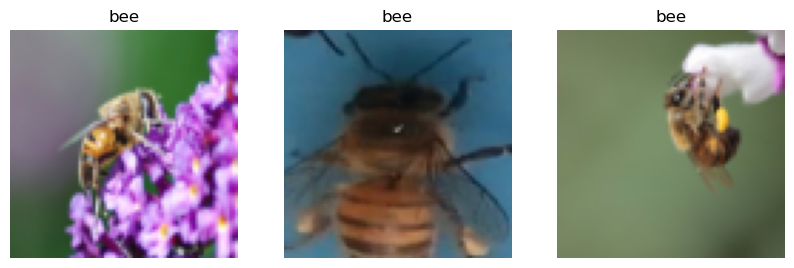

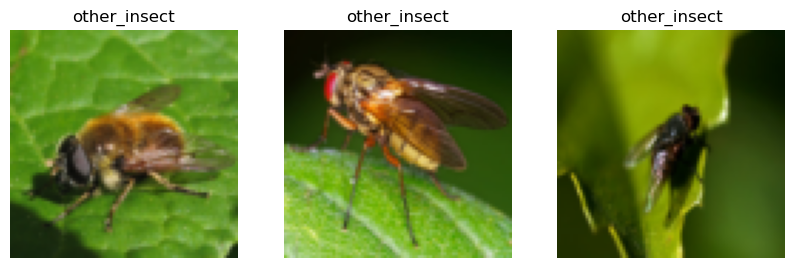

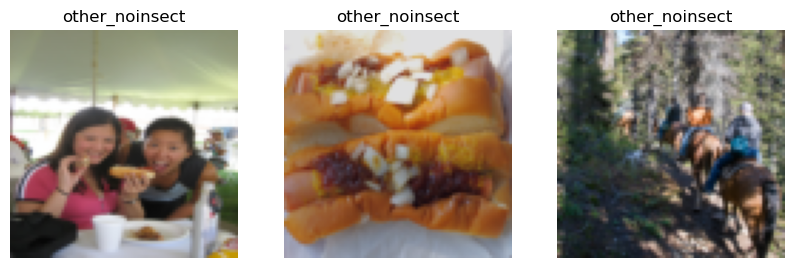

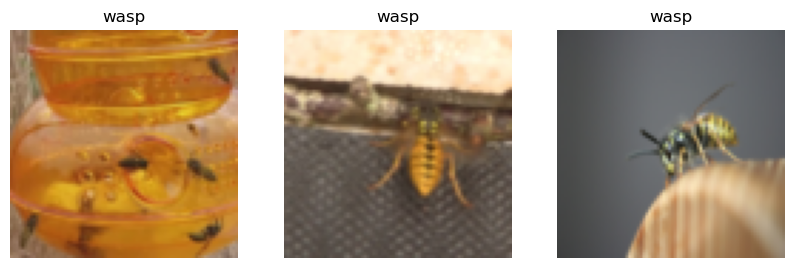

In [5]:
# The data path should be set from the cell above.
# If that failed and you want to set it manually, uncomment the line below.
# data_path = "data/bee_vs_wasp"


class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.samples = []

        for class_name in self.classes:
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    if img_name.lower().endswith((".png", ".jpg", ".jpeg")):
                        self.samples.append(
                            (
                                os.path.join(class_path, img_name),
                                self.class_to_idx[class_name],
                            )
                        )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


def load_display_data(path, batch_size=32, shape=(80, 80, 3), show_pictures=True):
    """Takes a path, batch size, target shape for images and optionally whether to show sample images.
    Returns training and testing datasets
    """
    print("***********************************************************************")
    print("Load data:")
    print(f"  - Loading the dataset from: {path}.")
    print(f"  - Using a batch size of: {batch_size}.")
    print(f"  - Resizing input images to: {shape}.")
    print("***********************************************************************")

    # Define transforms
    transform = transforms.Compose(
        [
            transforms.Resize((shape[0], shape[1])),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ]
    )

    # Create dataset
    full_dataset = CustomImageDataset(path, transform=transform)

    # Split into train and test
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    X_train, X_val = torch.utils.data.random_split(
        full_dataset,
        [train_size, test_size],
        generator=torch.Generator().manual_seed(123),
    )

    # Create data loaders
    train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True,
                             num_workers=num_workers)
    test_loader = DataLoader(X_val, batch_size=batch_size, shuffle=False, 
                             num_workers=num_workers)

    if show_pictures:
        # Get the class names
        class_names = full_dataset.classes
        print(class_names)

        # Display up to 3 images from each of the categories
        for i, class_name in enumerate(class_names):
            plt.figure(figsize=(10, 10))
            count = 0
            for images, labels in train_loader:
                # Convert to numpy for display
                images_np = images.numpy()
                labels_np = labels.numpy()

                # Filter images of the current class
                class_mask = labels_np == i
                class_images = images_np[class_mask]

                if len(class_images) > 0:
                    # Number of images to show (limited by number in batch or 3)
                    num_images = min(len(class_images), 3 - count)

                    for j in range(num_images):
                        ax = plt.subplot(1, 3, count + j + 1)
                        # Denormalize for display
                        img = class_images[j].transpose(1, 2, 0)
                        img = img * np.array([0.229, 0.224, 0.225]) + np.array(
                            [0.485, 0.456, 0.406]
                        )
                        img = np.clip(img, 0, 1)
                        plt.imshow(img)
                        plt.title(class_name)
                        plt.axis("off")

                    count += num_images
                    if count >= 3:
                        break
            plt.show()

    return train_loader, test_loader


X_train, X_val = load_display_data(
    data_path, batch_size=32, shape=(80, 80, 3), show_pictures=True
)

## 4. Make our model

This function creates the model we will use.

One hyperparameter to explore is the activation function, which is set when making the model. We start with a ReLU as the default, but you can try others. For simplicity, we will use the same activation function for all but the last layer of the model, but you could change them individually.

The last layer will almost always use a Softmax, which makes all the output values between 0 and 1 and sum to 1, transforming them into probabilities of the input belonging to each possible class.

In [6]:
class CNNClassifier(pl.LightningModule):
    def __init__(
        self,
        activation="relu",
        shape=(80, 80, 3),
        num_classes=4,
        learning_rate=0.001,
        optimizer_name="Adam",
    ):
        super().__init__()
        self.save_hyperparameters()

        # Define the model architecture
        self.conv1 = nn.Conv2d(shape[2], 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Calculate the size after convolutions and pooling
        conv_output_size = (
            (shape[0] // 8) * (shape[1] // 8) * 128
        )  # 3 pooling layers with stride 2

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(conv_output_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

        # Set activation function
        if activation == "relu":
            self.activation = F.relu
        elif activation == "tanh":
            self.activation = torch.tanh
        elif activation == "sigmoid":
            self.activation = torch.sigmoid
        else:
            self.activation = F.relu

        self.learning_rate = learning_rate
        self.optimizer_name = optimizer_name

    def forward(self, x):
        x = self.pool1(self.activation(self.conv1(x)))
        x = self.pool2(self.activation(self.conv2(x)))
        x = self.pool3(self.activation(self.conv3(x)))
        x = self.flatten(x)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()

        # Log training metrics
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()

        # Log validation metrics
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        if self.optimizer_name.lower() == "adam":
            optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_name.lower() == "sgd":
            optimizer = optim.SGD(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_name.lower() == "adagrad":
            optimizer = optim.Adagrad(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_name.lower() == "rmsprop":
            optimizer = optim.RMSprop(self.parameters(), lr=self.learning_rate)
        else:
            optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


def make_model(activation="relu", shape=(80, 80, 3), num_classes=4):
    """Sets up a model.
    Takes in an activation function, shape for the input images, and number of classes.
    Returns the model.
    """
    print("***********************************************************************")
    print("Make model:")
    print(f"  - Using the activation function: {activation}.")
    print(f"  - Model will have {num_classes} classes.")
    print("***********************************************************************")

    model = CNNClassifier(activation=activation, shape=shape, num_classes=num_classes)
    return model


model = make_model()
print(model)

***********************************************************************
Make model:
  - Using the activation function: relu.
  - Model will have 4 classes.
***********************************************************************
CNNClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=12800, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)


## 5. Create the trainer and train the model

This step gets it ready for training and trains the model. The primary hyperparameters here are:
* the **loss function** (how we determine how close the predicted output is from the known output values),
* the **optimization function** (how we determine what parameters should be updated and how),
* the **learning rate** (how much each parameter should be adjusted),
* and how many **epochs** should be run (remember, an epoch is a full pass through all the training data).

In [7]:
class MetricsCallback(Callback):
    def __init__(self):
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []

    def on_train_epoch_end(self, trainer, pl_module):
        # Get logged metrics
        if "train_loss" in trainer.logged_metrics:
            self.train_losses.append(trainer.logged_metrics["train_loss"].item())
        if "train_acc" in trainer.logged_metrics:
            self.train_accuracies.append(trainer.logged_metrics["train_acc"].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        if "val_loss" in trainer.logged_metrics:
            self.val_losses.append(trainer.logged_metrics["val_loss"].item())
        if "val_acc" in trainer.logged_metrics:
            self.val_accuracies.append(trainer.logged_metrics["val_acc"].item())


def compile_train_model(
    X_train,
    X_val,
    model,
    loss="CrossEntropyLoss",
    optimizer="Adam",
    learning_rate=0.0001,
    epochs=10,
):
    """Compiles and trains the model.
    Takes in an X_train, X_val, model, loss function, optimizer, learning rate,
    and epochs.
    Returns the compiled model and training history.
    """
    print("***********************************************************************")
    print("Compile and Train the model:")
    print(f"  - Using the loss function: {loss}.")
    print(f"  - Using the optimizer: {optimizer}.")
    print(f"  - Using learning rate of: {learning_rate}.")
    print(f"  - Running for {epochs} epochs.")
    print("***********************************************************************")

    # Update model hyperparameters
    model.learning_rate = learning_rate
    model.optimizer_name = optimizer

    # Create metrics callback to capture training history
    metrics_callback = MetricsCallback()

    # Create trainer
    trainer = Trainer(
        max_epochs=epochs,
        enable_progress_bar=True,
        log_every_n_steps=50,
        callbacks=[metrics_callback],
    )

    # Train the model
    trainer.fit(model, X_train, X_val)

    # Return model and training history
    history = {
        "train_loss": metrics_callback.train_losses,
        "train_acc": metrics_callback.train_accuracies,
        "val_loss": metrics_callback.val_losses,
        "val_acc": metrics_callback.val_accuracies,
    }

    return model, history


model, history = compile_train_model(X_train, X_val, model, epochs=2)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/project/scinet_workshop1/deep_learning_foundations/dlf_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-699906cb-632a-55d7-90a4-509e2fff81da]


***********************************************************************
Compile and Train the model:
  - Using the loss function: CrossEntropyLoss.
  - Using the optimizer: Adam.
  - Using learning rate of: 0.0001.
  - Running for 2 epochs.
***********************************************************************



  | Name    | Type      | Params | Mode 
----------------------------------------------
0 | conv1   | Conv2d    | 896    | train
1 | pool1   | MaxPool2d | 0      | train
2 | conv2   | Conv2d    | 18.5 K | train
3 | pool2   | MaxPool2d | 0      | train
4 | conv3   | Conv2d    | 73.9 K | train
5 | pool3   | MaxPool2d | 0      | train
6 | flatten | Flatten   | 0      | train
7 | fc1     | Linear    | 1.6 M  | train
8 | fc2     | Linear    | 516    | train
----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.929     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


## 6. Evaluate the model

Now that we have trained our model, let's evaluate how it does.


***********************************************************************
Evaluate the model:
***********************************************************************

Note that PyTorch Lightning evaluates the model with the validation
dataset, so epoch 0 is before training and only has validation values.
Training history data not available for plotting

Evaluating model on validation set...this may take a bit of time.
Validation loss: 0.7451
Validation accuracy: 0.6845


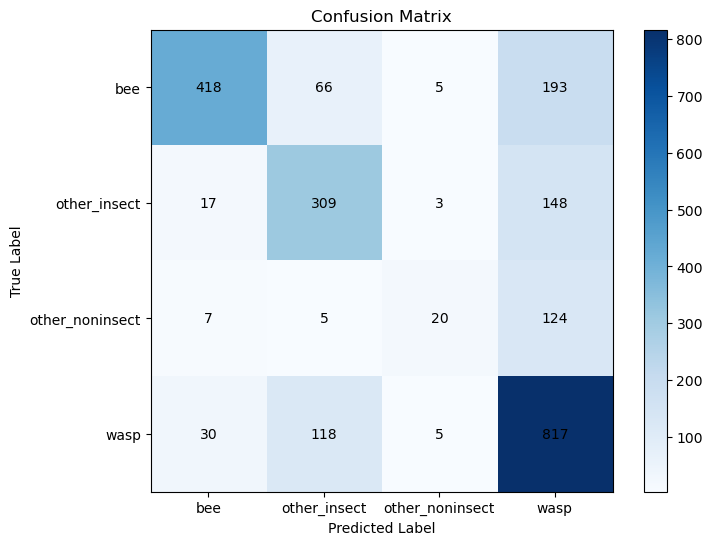

In [8]:
def evaluate_model(X_val, model, history=None, num_classes=4):
    """Evaluates a model.
    Takes in an X_val, model, history, number of classes.
    """
    print("***********************************************************************")
    print("Evaluate the model:")
    print("***********************************************************************")

    print("\nNote that PyTorch Lightning evaluates the model with the validation")
    print("dataset, so epoch 0 is before training and only has validation values.")

    # Plot training history if provided
    if history is not None and isinstance(history, dict):
        train_losses = history.get("train_loss", [])
        val_losses = history.get("val_loss", [])
        train_accuracies = history.get("train_acc", [])
        val_accuracies = history.get("val_acc", [])

        # If we have the data, plot it
        if train_losses and val_losses:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

            # Plot loss - handle different lengths
            # Training losses correspond to epochs 1, 2, 3, etc.
            train_epochs = range(1, len(train_losses) + 1)
            # Validation losses include initial validation (epoch 0) plus after each training epoch
            val_epochs = range(0, len(val_losses))

            ax1.plot(
                train_epochs, train_losses, "b-o", label="Training Loss", markersize=4
            )
            ax1.plot(
                val_epochs, val_losses, "r-s", label="Validation Loss", markersize=4
            )
            ax1.set_title("Training and Validation Loss")
            ax1.set_xlabel("Epoch")
            ax1.set_ylabel("Loss")
            ax1.legend()
            ax1.grid(True)

            # Add text annotation explaining the validation baseline
            ax1.text(
                0.02,
                0.98,
                "Val epoch 0 = baseline\n(before training)",
                transform=ax1.transAxes,
                fontsize=9,
                verticalalignment="top",
                bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8),
            )

            # Plot accuracy - use same epoch alignment as for losses
            if train_accuracies or val_accuracies:
                if train_accuracies:
                    train_acc_epochs = range(1, len(train_accuracies) + 1)
                    ax2.plot(
                        train_acc_epochs,
                        train_accuracies,
                        "b-o",
                        label="Training Accuracy",
                        markersize=4,
                    )

                if val_accuracies:
                    val_acc_epochs = range(0, len(val_accuracies))
                    ax2.plot(
                        val_acc_epochs,
                        val_accuracies,
                        "r-s",
                        label="Validation Accuracy",
                        markersize=4,
                    )

                ax2.set_title("Training and Validation Accuracy")
                ax2.set_xlabel("Epoch")
                ax2.set_ylabel("Accuracy")
                ax2.legend()
                ax2.grid(True)
            else:
                ax2.text(
                    0.5,
                    0.5,
                    "Accuracy data not available",
                    horizontalalignment="center",
                    verticalalignment="center",
                    transform=ax2.transAxes,
                )
                ax2.set_title("Training and Validation Accuracy")

            plt.tight_layout()
            plt.show()
        else:
            print("Training history data not available for plotting")
    else:
        print("Training history not provided - cannot plot training history")

    print("\nEvaluating model on validation set...this may take a bit of time.")
    # Get predictions for confusion matrix
    model.eval()
    all_preds = []
    all_labels = []

    total_loss = 0
    correct = 0
    total = 0

    # Get class names (assuming they exist)
    try:
        # Try to get class names from the first dataset in X_val
        class_names = [
            "bee",
            "other_insect",
            "other_noninsect",
            "wasp",
        ]  # Default class names
    except:
        class_names = [f"Class_{i}" for i in range(num_classes)]

    with torch.no_grad():
        for batch in X_val:
            x, y = batch
            y_hat = model(x)
            loss = F.cross_entropy(y_hat, y)
            total_loss += loss.item()

            pred = y_hat.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)

            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    avg_loss = total_loss / len(X_val)
    accuracy = correct / total

    print(f"Validation loss: {avg_loss:.4f}")
    print(f"Validation accuracy: {accuracy:.4f}")

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(range(num_classes), class_names)
    plt.yticks(range(num_classes), class_names)
    plt.colorbar()
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
    plt.show()


evaluate_model(X_val, model, history)

## 7. Explore hyperparameters!

OK, we've trained the model once using some decent first guesses. As you can see in the Training and Validation Accuracy over Time graph above, the model's accuracy improved against the training data, but it's validation accuracy stayed pretty stagnant. What do you think that says about the model? Do you think the model is overfitting, underfitting, or just right? If you're not sure, you can refer back to Module 3, How to Tune Your Model, for a refresher.

In the Confusion Matrix above, we can see that the model is doing a good job of classifying wasps, but not so well with other insects. Why do you think that is? What could we do to improve the model's performance?

Now, we can see if we can do better by exploring different hyperparameters.

While there are methods to explore different hyperparameters systematically and track the results more efficiently, we will rely on some ad-hoc exploration and keep everything in the notebook.

The following function pulls all the steps from above into a single function.

In [9]:
def the_whole_shebang(
    path, batch_size, shape, classes, activation, loss, optimizer, show_pictures=True
):

    X_train, X_val = load_display_data(path, batch_size, shape, show_pictures)
    model = make_model(activation=activation, shape=shape, num_classes=classes)
    model, history = compile_train_model(
        X_train,
        X_val,
        model,
        loss=loss,
        optimizer=optimizer,
        learning_rate=learning_rate,
        epochs=epochs,
    )
    evaluate_model(X_val, model, history, classes)

### Copy the next cell and change hyperparameters

You can copy the next cell multiple times and adjust the hyperparameters to compare results.

***********************************************************************
Load data:
  - Loading the dataset from: /project/scinet_workshop1/dlf_workshop_data/bee_vs_wasp.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
***********************************************************************
['bee', 'other_insect', 'other_noinsect', 'wasp']


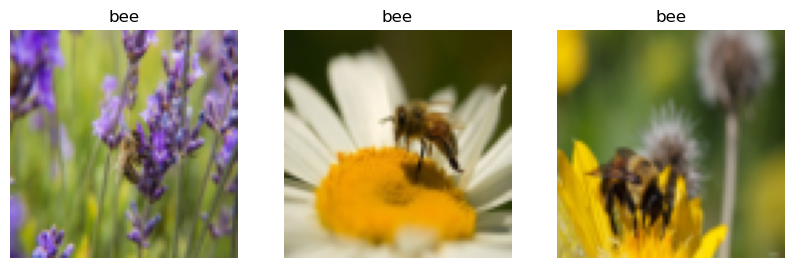

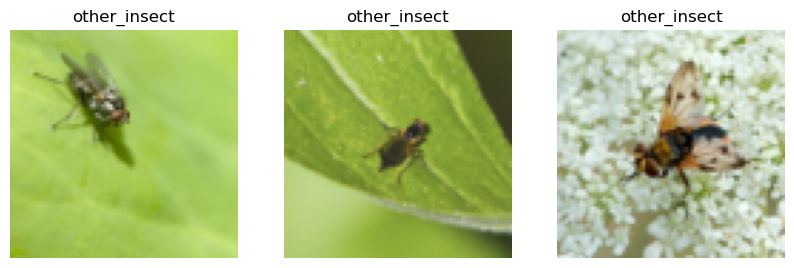

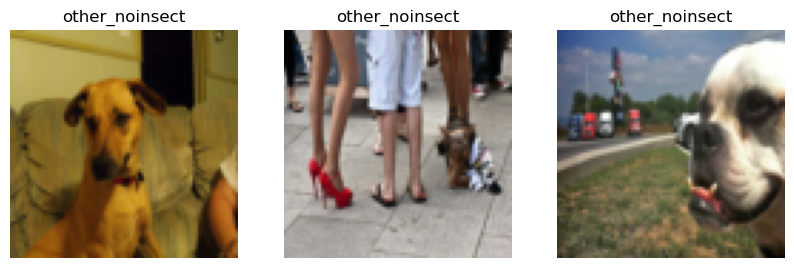

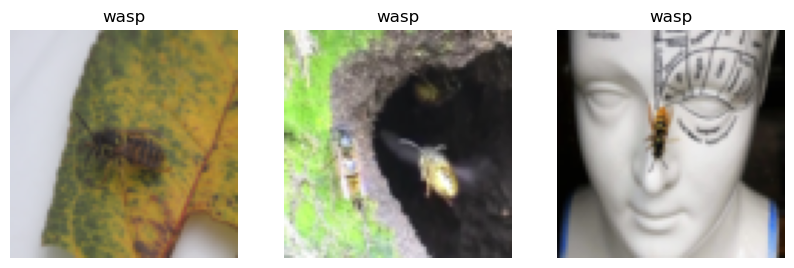

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-699906cb-632a-55d7-90a4-509e2fff81da]

  | Name    | Type      | Params | Mode 
----------------------------------------------
0 | conv1   | Conv2d    | 896    | train
1 | pool1   | MaxPool2d | 0      | train
2 | conv2   | Conv2d    | 18.5 K | train
3 | pool2   | MaxPool2d | 0      | train
4 | conv3   | Conv2d    | 73.9 K | train
5 | pool3   | MaxPool2d | 0      | train
6 | flatten | Flatten   | 0      | train
7 | fc1     | Linear    | 1.6 M  | train
8 | fc2     | Linear    | 516    | train
----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.929     To

***********************************************************************
Make model:
  - Using the activation function: relu.
  - Model will have 4 classes.
***********************************************************************
***********************************************************************
Compile and Train the model:
  - Using the loss function: CrossEntropyLoss.
  - Using the optimizer: Adam.
  - Using learning rate of: 0.001.
  - Running for 10 epochs.
***********************************************************************


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# data_path = 'data/bee_vs_wasp/' # Path to the data.
# This is defined above, only need to change if you change datasets

show_pictures = True  # Show sample images from the dataset? Keep on at first, but may become distracting.
# Set to False to turn off
# Hyperparameters
shape = (80, 80, 3)  # Dimensions to use for the images...the raw data are 80x80
#  color images, but you could down-sample them
#  or convert them to black and white if you wanted
batch_size = 32  # What batch size to use
classes = (
    4  # We have 4 classes in our dataset: bee, wasp, other_insect, other_noninsect
)
# Only change this if you change the dataset
activation = "relu"  # The activation function is an important hyperparameter
# Other activations functions to try: tanh, sigmoid

loss = "CrossEntropyLoss"  # Loss function for multi-class classification
# PyTorch uses CrossEntropyLoss for multi-class classification

optimizer = "Adam"  # Optimizer: others to try: Adam, RMSprop, Adagrad, SGD

learning_rate = (
    0.001  # Try increasing or decreasing the learning rate by an order of magnitude
)

epochs = 10  # Try running more epochs

# Run everything with these hyperparameters
the_whole_shebang(
    data_path, batch_size, shape, classes, activation, loss, optimizer, show_pictures
)

----
## Push changes to GitHub <img src="https://github.com/PracticumAI/deep_learning_pt-lightning/blob/main/images/push_to_github.png?raw=1" alt="Push to GitHub icon" align="right" width=150>

 Remember to **add**, **commit**, and **push** the changes you have made to this notebook to GitHub to keep your repository in sync.

In Jupyter, those are done in the git tab on the left. In Google Colab, use File > Save a copy in GitHub.